In [2]:
%load_ext autoreload
%autoreload 2

In [22]:
import numpy as np

import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
from matplotlib import pyplot as plt
from matplotlib import colors
from matplotlib.colors import ListedColormap
import webcolors
from PIL import Image, ImageDraw

import networkx as nx

from minimal.layout import NodeType, NODE_COLOR
from minimal.gen import PlanMasks
from minimal.rooms import RoomAreas, extract_rooms
from minimal.walls import (
    extract_walls,
    BOUNDARY_TOP,
    BOUNDARY_RIGHT,
    BOUNDARY_BOTTOM,
    BOUNDARY_LEFT,
)

%matplotlib inline

In [4]:
cmapr = ListedColormap(['white', *plt.get_cmap('tab10').colors])
cmapw = ListedColormap(['white', 'black', *plt.get_cmap('tab10').colors])

In [5]:
%%time
pm = PlanMasks.create_from_state(torch.load("data/plan_masks_05.pth"))
rooms = extract_rooms(pm)

CPU times: user 838 ms, sys: 707 µs, total: 838 ms
Wall time: 838 ms


In [6]:
rect_mask = sum(room.to_mask() * (i + 1) for i, room in enumerate(rooms))
walls_mask, orient_mask = extract_walls(rooms)

In [113]:
scale_val = 4

scale_x = scale_val
scale_y = scale_val

out_size = 64 * scale_val

In [114]:
def scale_orientation(
    out_mask,
    orient_mask,
    target_orientation,
    scale_x: int, scale_y: int,
    dup_x: bool, dup_y: bool,
    shift_x: bool, shift_y: bool,
):
    loc_x, loc_y = torch.where(orient_mask & target_orientation > 0)

    loc_x *= scale_x
    loc_y *= scale_y

    loc_x = torch.cat([loc_x + i * int(dup_x) for i in range(scale_x)])
    loc_y = torch.cat([loc_y + i * int(dup_y) for i in range(scale_y)])

    loc_x += (scale_x - 1) * int(shift_x)
    loc_y += (scale_y - 1) * int(shift_y)

    out_mask[loc_x, loc_y] = 1

big_walls_mask = torch.zeros((out_size, out_size), dtype=torch.uint8)

scale_orientation(big_walls_mask, orient_mask, BOUNDARY_TOP, scale_x, scale_y, 0, 1, 0, 0)
scale_orientation(big_walls_mask, orient_mask, BOUNDARY_RIGHT, scale_x, scale_y, 1, 0, 0, 1)
scale_orientation(big_walls_mask, orient_mask, BOUNDARY_BOTTOM, scale_x, scale_y, 0, 1, 1, 0)
scale_orientation(big_walls_mask, orient_mask, BOUNDARY_LEFT, scale_x, scale_y, 1, 0, 0, 0)

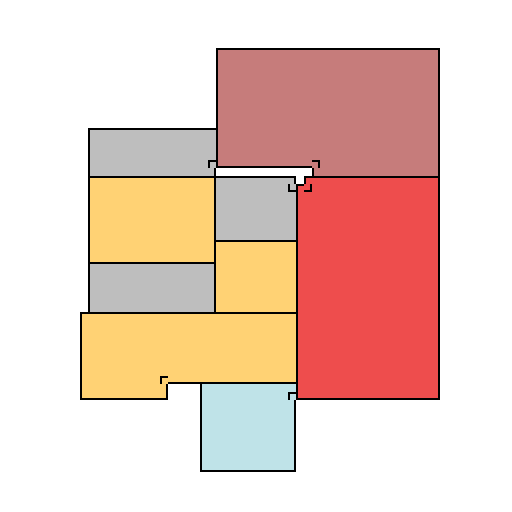

In [115]:
h = rooms[0].grid_height
w = rooms[0].grid_width

plan_img = Image.new("RGB", (w, h), (255, 255, 255))
draw = ImageDraw.Draw(plan_img)

for room in rooms:
    m = room.to_mask()
    n = room.room_type

    mask_bitmap = Image.fromarray(m.numpy() * 255, mode="L")
    r, g, b = webcolors.hex_to_rgb(NODE_COLOR[n])
    draw.bitmap((0, 0), mask_bitmap, fill=(r, g, b))

# mask_bitmap = Image.fromarray(walls_mask.numpy() * 255, mode="L")
# draw.bitmap((0, 0), mask_bitmap, fill=(0, 0, 0))

plan_img = plan_img.resize((out_size, out_size), Image.Resampling.BOX)

mask_bitmap = Image.fromarray(big_walls_mask.numpy() * 255, mode="L")
ImageDraw.Draw(plan_img).bitmap((0, 0), mask_bitmap, fill=(0, 0, 0))

plan_img.resize((512,512), Image.Resampling.BOX)

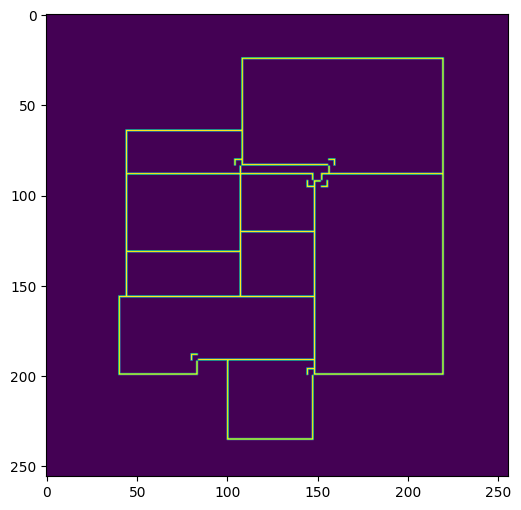

In [116]:
plt.figure(figsize=(12,6))

plt.imshow(big_walls_mask)